In [1]:
import math
from matplotlib import pyplot as plt
import timeit
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from novelty.models.cnn import CNN
from novelty.models.mlp import MLP

/Users/akshay/opt/anaconda3/envs/novelty/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Vanilla Model Training

In [9]:
def train(model, device, train_loader, optimizer, epoch, 
         log_interval = 100):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
    return train_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    return test_loss / len(test_loader.dataset), correct / len(test_loader.dataset)
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))

In [3]:
use_gpu = False
device = torch.device("mps" if use_gpu else "cpu")

In [4]:
epochs = 10
train_kwargs = {'batch_size': 100}
test_kwargs = {'batch_size': 1000}
if use_gpu:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # image mean and std 
    ])

In [5]:
dataset1 = datasets.MNIST('../data/raw', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data/raw', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [6]:
model = MLP().to(device)
optimizer = optim.Adam(model.parameters())

In [7]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.07s/it]


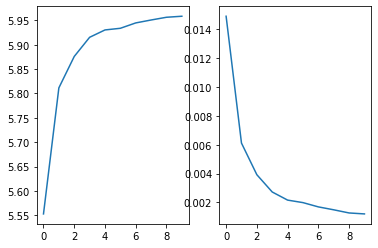

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_losses)
ax2.plot(train_accs)
plt.show()

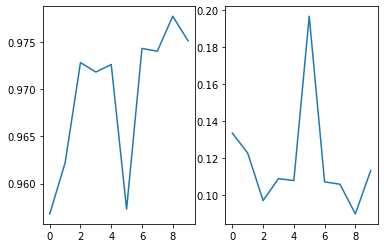

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(test_losses)
ax2.plot(test_accs)
plt.show()

# Streaming Training

In a datastreaming context, we assume that the model can only see each of the 60000 training examples once. Therefore, we'd like to maximize the information gain from each training example. We'll still use 10 epochs, but each epoch will only be 10000 examples. 

In [11]:
examples_per_epoch = 1000
batches_per_epoch = examples_per_epoch//train_kwargs['batch_size']
epochs = len(train_loader.dataset)//examples_per_epoch

In [12]:
def train_streaming(model, device, train_loader, optimizer, epoch, 
         epoch_size = 100, examples_per_epoch = 10000, log_interval = 100):
    model.train()
    train_loss = 0
    correct = 0 
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx < epoch_size * (epoch-1):
            continue 
        if batch_idx >= epoch_size * epoch:
            break
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
    return train_loss / examples_per_epoch, correct / examples_per_epoch

In [13]:
model = MLP().to(device)
optimizer = optim.Adam(model.parameters())

In [14]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_acc = train_streaming(model, device, train_loader, optimizer, epoch, batches_per_epoch, examples_per_epoch)
    test_loss, test_acc = test(model, device, test_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [03:17<00:00,  3.29s/it]


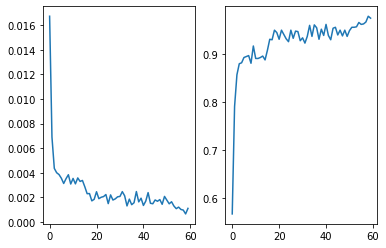

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_losses)
ax2.plot(train_accs)
plt.show()

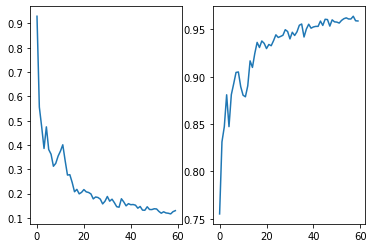

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(test_losses)
ax2.plot(test_accs)
plt.show()

# Unbalanced Streaming Training

Unlike in the previous streaming context, we'll use rejection sampling to create an unbalanced distribution over the 10 mnist letters as they stream in. The goal here will be to ensure that model sees more 0s than 1s than 2s etc. For an initial probability distribution, I'll use Benford's law, which is based on the frequency of first digits in data: P(d) = log10(1 + 1/d) . Because we have 10 (rather than 9) digits, we'll use P(d) = log11(1+1/d)

In [36]:
def benford_dist(digit, base=11):
    return torch.log(1 + 1/(digit+1))/math.log(base)

In [82]:
benford_probs = benford_dist(torch.arange(0,10))
M = max(benford_probs)

In [83]:
def instrumental_dist(digits, M):
    return M*torch.rand(digits.shape)

In [84]:
kept = []
for batch_idx, (data, target) in enumerate(train_loader):
    mask = instrumental_dist(target, M) < benford_dist(target) 
    kept += target[mask].tolist()
kept = torch.tensor(kept)

In [85]:
torch.bincount(kept)

tensor([5923, 3890, 2476, 1996, 1602, 1214, 1139, 1031,  928,  855])

In [81]:
M

tensor(0.1691)